In [17]:
from PIL import Image
import os
import torch
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split


# Read the JSON file
with open('hist_eval.json', 'r') as file:
    labels_data = json.load(file)

# Extract image names and critical scores
# image_names = list(labels_data.keys())
image_names_from_json = list(labels_data.keys())
image_names_with_raw_suffix = ["./critical_hist_chunk_test/_corrected_cells/"+ name[:-4] + '_raw.jpg' for name in image_names_from_json]

critical_scores = [labels_data[image]['citicality_score'] for image in image_names_from_json]

#critical score and image names loaded from hist_eval.json

2023-06-26_06-35-17_C50_a14 47
2023-06-26_06-35-17_C50_a17 21
2023-06-26_06-35-17_C50_a19 24
2023-06-26_06-35-17_C50_a21 31
2023-06-26_06-35-17_C50_a26 21


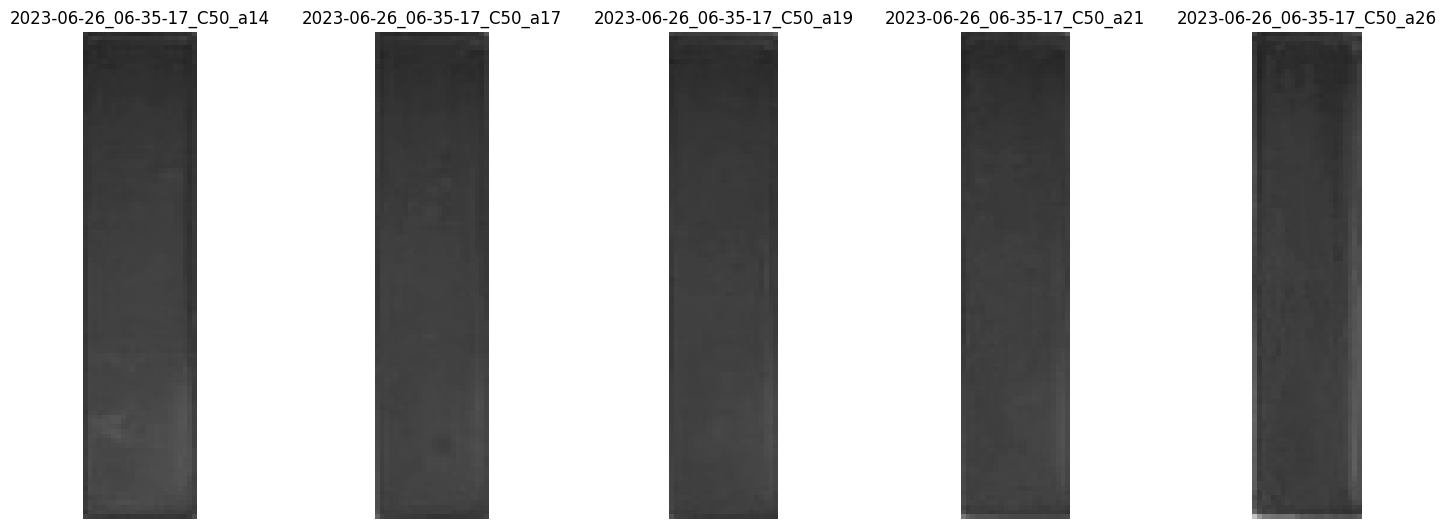

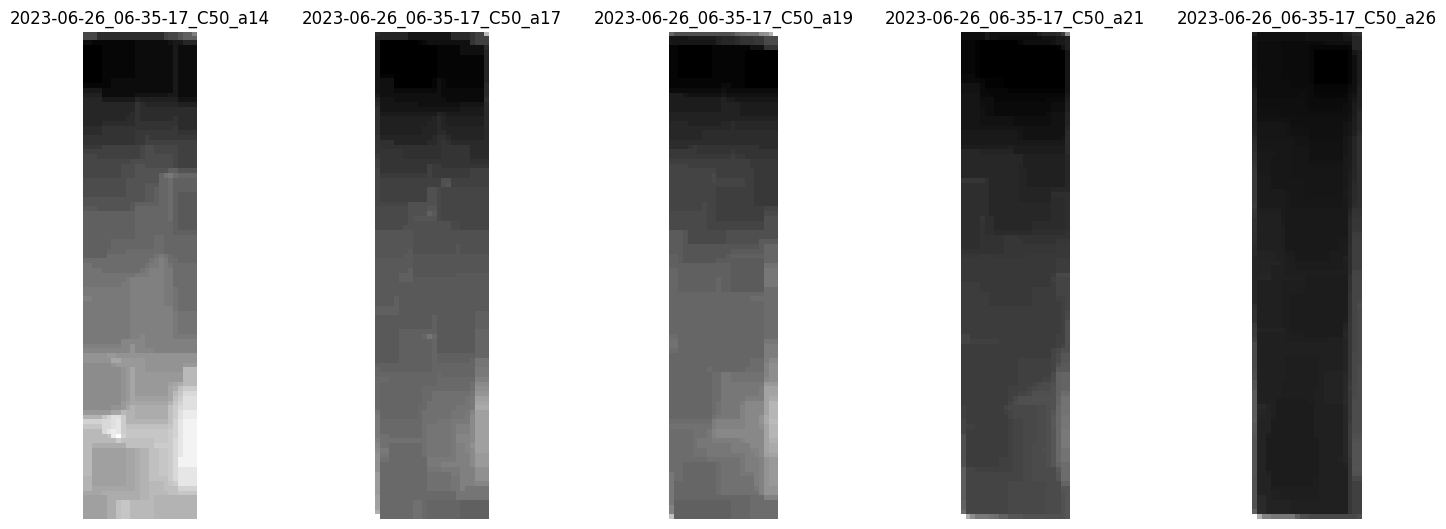

In [4]:

def preprocess_image(image_path):
    # Load image as grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # blurred_image = cv2.GaussianBlur(image, (9, 9), 2) 

    #morphologyical filter applied
    kernel = np.ones((7, 7), np.uint8)
    morph_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    return morph_image

# Preprocess all images and store them in a list
preprocessed_images = [preprocess_image(image_path) for image_path in image_names_with_raw_suffix]

# Set the maximum width for plots
plt.rcParams["figure.figsize"] = (15, 6)

# Create subplots for original images
fig, axs = plt.subplots(1, 5)
fig.tight_layout(pad=3.0)

for i in range(10,15):
    image_path = image_names_with_raw_suffix[i]
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i-10].imshow(image)
    axs[i-10].set_title('{}'.format(image_names_from_json[i][:27]))  # Display first 20 characters of the name
    axs[i-10].axis('off')

# Save the figure with maximum width
plt.savefig('original_images.png', bbox_inches='tight')

# Create subplots for preprocessed images
fig, axs = plt.subplots(1, 5)
fig.tight_layout(pad=3.0)

for i in range(10,15):
    image_path = image_names_with_raw_suffix[i]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply Sobel edge detection
    axs[i-10].imshow(preprocessed_images[i], cmap='gray')
    axs[i-10].set_title('{}'.format(image_names_from_json[i][:27]))  # Display first 20 characters of the name
    axs[i-10].axis('off')
    print(image_names_from_json[i][:27],critical_scores[i])
# Save the figure with maximum width
plt.savefig('preprocessed_images.png', bbox_inches='tight')

plt.show()

#5 of the original and corresponding preprocessed images displayed 

In [13]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transform to resize the images to the desired dimensions
def resize_image(image, target_size):
    resized_image = cv2.resize(image, target_size)
    return resized_image

# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 26 * 6, 128)  # Adjusted input size after resizing
        self.fc2 = nn.Linear(128, 1)  # Output layer for regression

    def forward(self, x):
        # print(x.shape)
        x = self.pool(torch.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(torch.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 32 * 26 * 6)  # Adjusted input size after resizing
        # print(x.shape)
        x = torch.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        return x


# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

# Resize all images to a consistent size
target_size = (25, 105)  
resized_images = [resize_image(image, target_size) for image in preprocessed_images]

# Convert resized images and labels to PyTorch tensors
images_tensor = torch.tensor(resized_images, dtype=torch.float32).unsqueeze(1).to(device) 
labels_tensor = torch.tensor(critical_scores, dtype=torch.float32).unsqueeze(1).to(device)

# print(images_tensor)
# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_tensor, labels_tensor, test_size=0.2, random_state=42)

# Create PyTorch DataLoader for training and validation sets
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Maximum number of epochs
patience = 10      # Number of epochs to wait for improvement
best_val_loss = float('inf')
no_improvement = 0


# Train the model
# num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        # print(images.shape)
        outputs = model(images)
        # print(outputs.shape)
        # labels = labels.view(-1, 1)
        # print("lable",labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}, Validation Loss: {epoch_val_loss}")

    # Check for improvement in validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement = 0
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            break
# Save the trained model
torch.save(model.state_dict(), 'cnn_model.pth')

#Training done using the cnn model.

Epoch 1/100, Training Loss: 20.12296759532738, Validation Loss: 19.09576041716382
Epoch 2/100, Training Loss: 18.38420575896413, Validation Loss: 19.952905296383047
Epoch 3/100, Training Loss: 18.48763300984509, Validation Loss: 18.669023556816846
Epoch 4/100, Training Loss: 17.755604843541573, Validation Loss: 18.598711816888105
Epoch 5/100, Training Loss: 17.789944414585577, Validation Loss: 18.30326901342636
Epoch 6/100, Training Loss: 16.858142105454224, Validation Loss: 17.73674568377043
Epoch 7/100, Training Loss: 15.448644984362828, Validation Loss: 23.555885214554635
Epoch 8/100, Training Loss: 16.102760306867022, Validation Loss: 17.85641982860135
Epoch 9/100, Training Loss: 15.271308705140596, Validation Loss: 17.771387021344406
Epoch 10/100, Training Loss: 14.38165422800231, Validation Loss: 18.642791504250432
Epoch 11/100, Training Loss: 14.682147699824393, Validation Loss: 17.761185516988423
Epoch 12/100, Training Loss: 13.737746040437543, Validation Loss: 19.0529680252075

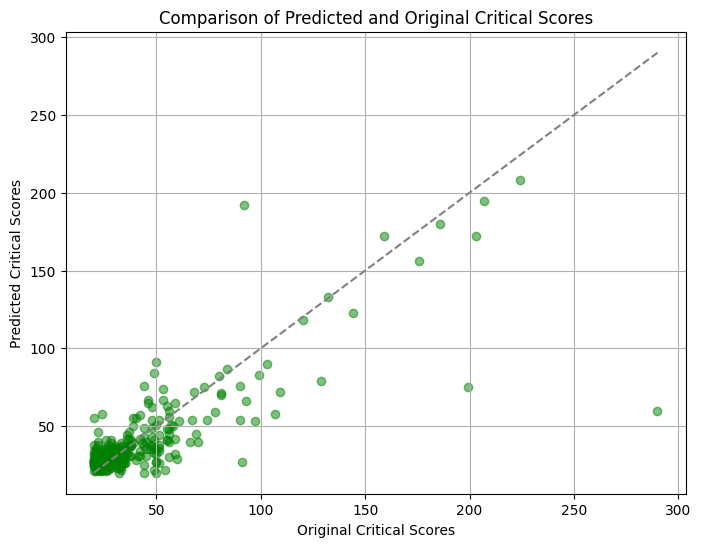

In [20]:
predicted_scores = []
original_scores = []

# Switch model to evaluation mode
model.eval()

# Iterate over validation dataset
with torch.no_grad():
    for images, labels in val_loader:
        # Forward pass
        outputs = model(images)
        # Convert predictions and labels to numpy arrays
        predicted_scores.extend(outputs.cpu().detach().numpy().flatten())
        original_scores.extend(labels.cpu().detach().numpy().flatten())

# Convert lists to numpy arrays
predicted_scores = np.array(predicted_scores)

# Clip the scores to have a minimum value of 20
predicted_scores = np.maximum(predicted_scores, 20)

# Round the scores to whole numbers
predicted_scores = np.round(predicted_scores)

# original_scores = np.array(original_scores)

# compare predicted_scores and original_scores using scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(original_scores, predicted_scores, color='green', alpha=0.5)
plt.plot([min(original_scores), max(original_scores)], [min(original_scores), max(original_scores)], color='grey', linestyle='--')
plt.title('Comparison of Predicted and Original Critical Scores')
plt.xlabel('Original Critical Scores')
plt.ylabel('Predicted Critical Scores')
plt.grid(True)
plt.show()

# compare]ison predicted_scores and original_scores displayed

In [21]:
# method to preprocess images in the folder
def preprocess_images_in_folder(folder_path):
    preprocessed_images = []
    image_names = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image(image_path)
            preprocessed_images.append(resize_image(preprocessed_image, target_size))
            image_names.append(filename)
    return preprocessed_images, image_names

folder_a_path = './critical_hist_chunk_test/_corrected_cells/'
preprocessed_images_folder_a, image_names_folder_a = preprocess_images_in_folder(folder_a_path)

# Load the trained model
model = CNN()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model.to(device)

# Make predictions
predicted_critical_scores = {}
for i in range(len(preprocessed_images_folder_a)):
    image = preprocessed_images_folder_a[i]
    image_name = image_names_folder_a[i]
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
    with torch.no_grad():
        output = model(image_tensor)
    predicted_critical_scores[image_name] = output.item()

# Iterate through the dictionary and modify the critical values to have a minimum value of 20 and to make values whole numbers
for key, value in predicted_critical_scores.items():
    # Check if the value is less than 20
    if value < 20:
        # Set the value to 20
        predicted_critical_scores[key] = 20
    else:
        # Round the score to a whole number
        predicted_critical_scores[key] = round(value)

# Save predicted critical scores to a JSON file
output_json_path = './predicted_critical_scores.json'
with open(output_json_path, 'w') as f:
    json.dump(predicted_critical_scores, f)

print("Predictions saved to:", output_json_path)

#predictions made for the whole dataset and saved to the json file

Predictions saved to: ./predicted_critical_scores.json
